In [1]:
#!/usr/bin/env python
import subprocess
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

In [2]:
'''
    Testing flood for TCP connections (proto=6)
'''
p = subprocess.run("rwfilter ./mysterious-dataset.rw --proto=6 --pass=stdout  --type=all | rwuniq --fields=sTime --sort-output --flows --no-columns --column-separator=' ' --no-title",
                    capture_output=True,
                    shell=True
                )

# I have had some problems using (rwfilter with SILK_DATA_ROOTDIR even with right silk.conf configurations) 
# the start-date and end-date filtering, problems which I don't know where they come from or how to solve.

# --start-date=2014/11/24:16 --end-date=2014/11/24:17
# --start-date=2014/11/24:16 --end-date=2014/12/01:13

if p.stderr:
    raise p.stderr.decode()

out = p.stdout.decode()

/tmp/ipykernel_271/3858787641.py:89: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  ax.locator_params(axis='x', nbins=10)


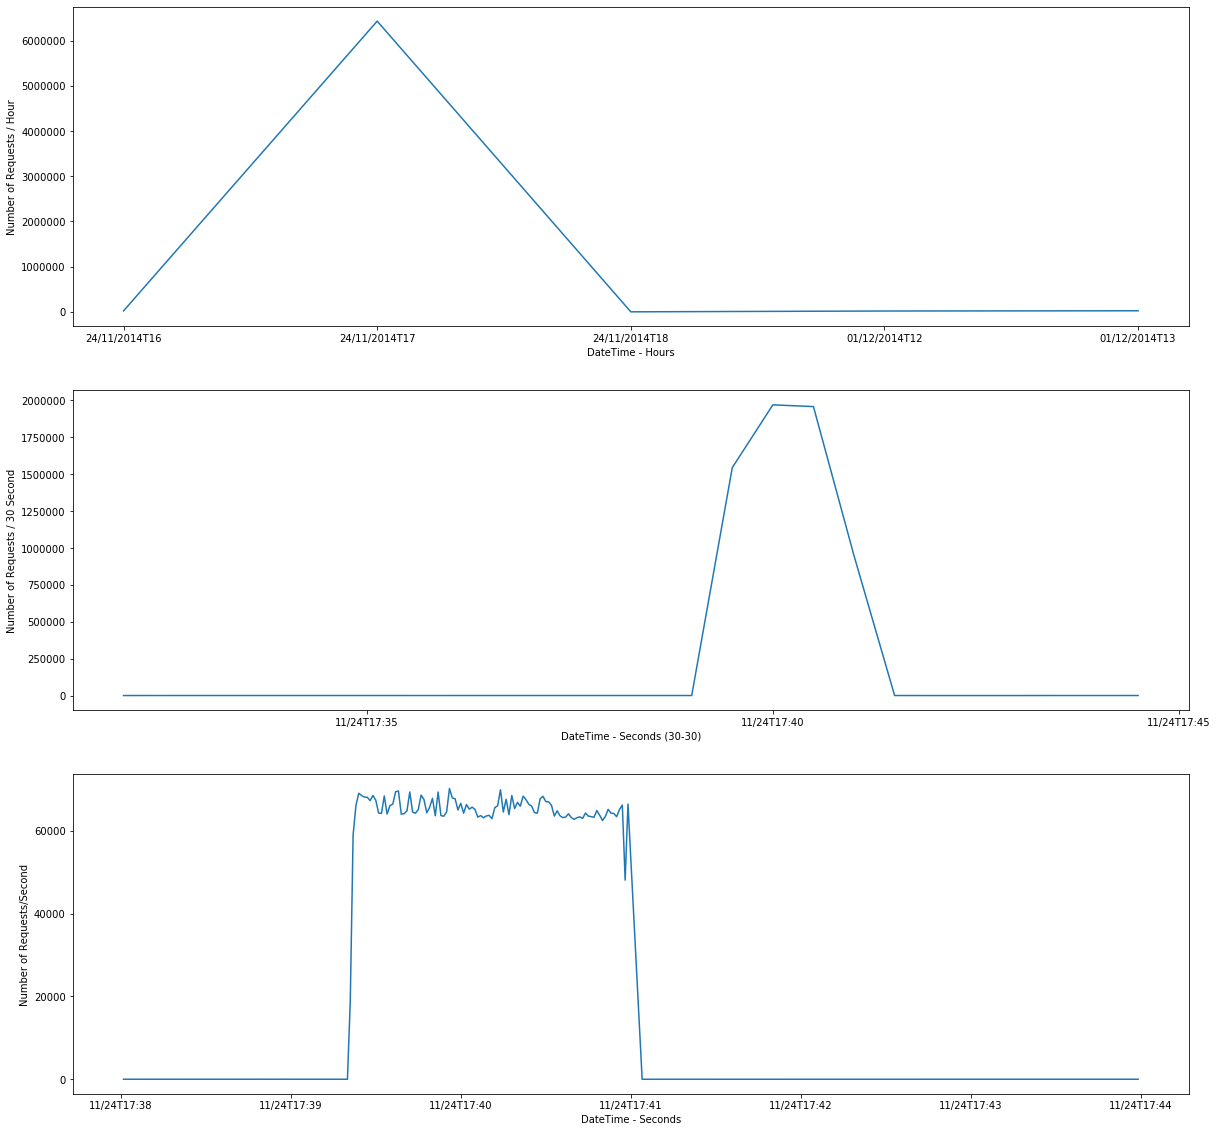

In [3]:
# key = x = dates
# values = y = count
dates_in_hours = dict()
dates_in_seconds = dict()
dates_in_seconds2 = dict()
t = out.splitlines()
for l in t:
    date_time,count = l.strip().split(' ')
    dt = datetime.strptime(date_time, '%Y/%m/%dT%H:%M:%S')
    
    ###  Add date counting ###
    
    ## seconds for details
    # More generalized /less filtered seconds
    if datetime.strptime('2014/11/24T17:38', '%Y/%m/%dT%H:%M') < dt < datetime.strptime('2014/11/24T17:44:00', '%Y/%m/%dT%H:%M:%S'):
        dates_in_seconds2[dt] = int(count)
    
    ## hours to get an aproximate time
    date_str = dt.strftime('%d/%m/%YT%H')
    if dates_in_hours.get(date_str):
        dates_in_hours[date_str] += int(count)
    else:
        dates_in_hours[date_str] = int(count)
            
    # More precise seconds
    if datetime.strptime('2014/11/24T17:32', '%Y/%m/%dT%H:%M') < dt < datetime.strptime('2014/11/24T17:45:00', '%Y/%m/%dT%H:%M:%S'):
        # round the seconds (00/30 seconds)
        
        s = dt.second
        if 0 < s < 15 or 30 < s < 45: # round down (reduce)
            if s > 30:
                s = s-30
            dt = dt - timedelta(seconds=s)
        elif 15 <= s < 30 or 45 <= s < 60: # round up (increase)
            if s > 30:
                s = s-30
            s = 30 - s
            dt = dt + timedelta(seconds=s)
        
        # append
        if dates_in_seconds.get(dt):
            dates_in_seconds[dt] += int(count)
        else:
            dates_in_seconds[dt] = int(count)


# hours
x = list(dates_in_hours.keys())
y = list(dates_in_hours.values())

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(3,1,1)
ax.plot(x, y)

ax.set_xlabel("DateTime - Hours")
ax.set_ylabel("Number of Requests / Hour")

#plt.show()

# seconds
x = list(dates_in_seconds.keys())
y = list(dates_in_seconds.values())
x = pd.to_datetime(x)

#plt.figure(figsize=(40, 10))
ax = fig.add_subplot(3,1,2)
ax.plot(x.to_pydatetime(), y)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%dT%H:%M'))

#ax.locator_params(axis='x', nbins=50)
#ax.locator_params(axis='y', nbins=7)

ax.set_xlabel("DateTime - Seconds (30-30)")
ax.set_ylabel("Number of Requests / 30 Second")

# seconds2
lx = list(dates_in_seconds2.keys())
y = list(dates_in_seconds2.values())
x = pd.to_datetime(lx)


ax = fig.add_subplot(3,1,3)

ax.plot(x.to_pydatetime(), y)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%dT%H:%M'))

ax.locator_params(axis='x', nbins=10)
ax.locator_params(axis='y', nbins=7)
ax.set_xlabel("DateTime - Seconds")
ax.set_ylabel("Number of Requests/Second")

plt.show()

#out


In [4]:
# With the sudden peak of requests not justified that is shown in the graph, we now know that there was an attack between 5h39PM-5h40PM
# Now we find out where the attack comes from, and to where it was directed

p = subprocess.run("rwfilter ./mysterious-dataset.rw --proto=6 --flags-all=S/S --pass=stdout  --type=all | rwuniq --fields=sTime,sip,dip --sort-output --flows --no-columns --column-separator=' ' --no-title",
                    capture_output=True,
                    shell=True
                )

if p.stderr:
    raise p.stderr.decode()

requests = dict()
for l in p.stdout.decode().splitlines():
    start_time, source_ip, destination_ip, count = l.strip().split(' ')
    count = int(count)
    dt = datetime.strptime(start_time, '%Y/%m/%dT%H:%M:%S')
    if datetime.strptime('2014/11/24T17:39', '%Y/%m/%dT%H:%M') < dt < datetime.strptime('2014/11/24T17:42:00', '%Y/%m/%dT%H:%M:%S') and count > 100:
        key: str = "src:'{}'/dest:'{}'".format(source_ip, destination_ip)
        if requests.get(key):
            requests[key] += count
        else:
            requests[key] = count

requests

{"src:'192.168.0.113'/dest:'192.168.0.200'": 1299095,
 "src:'192.168.0.200'/dest:'192.168.0.113'": 1288014}

With this, we can conclude that there is a SYN Flood occurring ina back and foward fashion between 192.168.0.113 and 192.168.0.200. The more suspected to be the atacker is 192.168.0.113 since it has more requests and probably started the flood, the others being only the tcp ports opened back to respond back.